In [ ]:
!pip install keras-tuner
!pip install holidays

In [ ]:
# Commented out IPython magic to ensure Python compatibility.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import datetime as dt
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv1D, MaxPooling1D, AveragePooling1D , Flatten, Input, LSTM, TimeDistributed
from sklearn.model_selection import train_test_split
import pprint as pp
import keras_tuner as kt
from tensorflow.keras.utils import plot_model
from sklearn.utils import shuffle


# For data processing
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

# For data processing and manipulation
import pandas as pd

# For date calculations
import datetime

# For encoding the label(word to onehot)
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

# For spliting the dataset into Train, Validation and Test
from sklearn.model_selection import train_test_split

from scipy.stats import hmean

from sklearn.preprocessing import MinMaxScaler

from sklearn.model_selection import KFold

# For evaluation metrices
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.metrics import classification_report

# For SOM
#from minisom import MiniSom

# For ploting data
import itertools
from itertools import cycle
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# For checking path
import os
from os import path
import csv


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


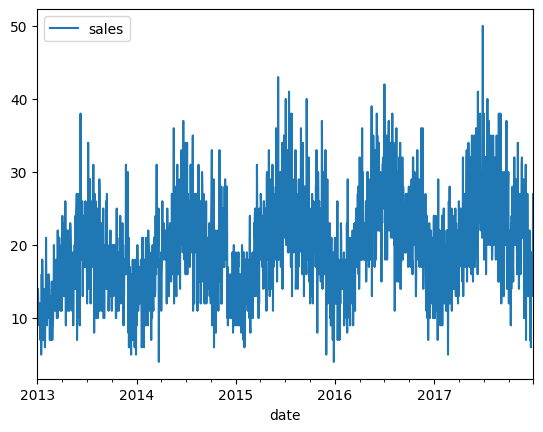

In [ ]:
df = pd.read_excel("/content/drive/MyDrive/dataset.xlsx")
df.plot(x = 'date', y = 'sales')
plt.show()

In [ ]:
df.shape

(1826, 3)

In [ ]:
df.head()

,Unnamed: 0,date,sales
0,0,2013-01-01,13
1,1,2013-01-02,11
2,2,2013-01-03,14
3,3,2013-01-04,13
4,4,2013-01-05,10


In [ ]:
df.drop(columns=df.columns[0], axis=1, inplace=True)

In [ ]:
df.head()

,date,sales
0,2013-01-01,13
1,2013-01-02,11
2,2013-01-03,14
3,2013-01-04,13
4,2013-01-05,10


In [ ]:
# Process the Dates column
df['date'] = pd.to_datetime(df['date'])

# Divide Dates into year, month, day, hour, minute
df['Year'] = df['date'].apply(lambda x: x.year)
df['Month'] = df['date'].apply(lambda x: x.month)
df['DayofMonth'] = df['date'].apply(lambda x: x.day)
df.head()

,date,sales,Year,Month,DayofMonth
0,2013-01-01,13,2013,1,1
1,2013-01-02,11,2013,1,2
2,2013-01-03,14,2013,1,3
3,2013-01-04,13,2013,1,4
4,2013-01-05,10,2013,1,5


In [ ]:
# Finding number of unique years
num_year = df['Year'].nunique()
num_year

5

In [ ]:
# Adding day of the week to the feature
df['DayOfWeek'] = df['date'].dt.day_name()
df.head()

,date,sales,Year,Month,DayofMonth,DayOfWeek
0,2013-01-01,13,2013,1,1,Tuesday
1,2013-01-02,11,2013,1,2,Wednesday
2,2013-01-03,14,2013,1,3,Thursday
3,2013-01-04,13,2013,1,4,Friday
4,2013-01-05,10,2013,1,5,Saturday


In [ ]:
# Dictionary for (Number,Day)
Week_day_n_d = {
    1 : "Sunday",
    2 : "Monday",
    3 : "Tuesday",
    4 : "Wednesday",
    5 : "Thursday",
    6 : "Friday",
    7 : "Saturday",
}

# Dictionary for (Day,Number)
Week_day_d_n = {key:value for (value,key) in Week_day_n_d.items()}

# Update the dataframe
df["WDay"] = df['DayOfWeek'].apply(lambda x: Week_day_d_n[x])

In [ ]:
import holidays
from datetime import date

bd_holidays = holidays.BD()

def is_holiday(date):
    # Ensure the date is in the correct format (date object)
    if isinstance(date, str):
        date = date.fromisoformat(date)
    return int(date in bd_holidays)

In [ ]:
df['is_holiday'] = df['date'].apply(is_holiday)

In [ ]:
df_new = pd.DataFrame(df.copy())
df_new.set_index('date', inplace=True)
df_new.index = pd.to_datetime(df_new.index)
df_new

,sales,Year,Month,DayofMonth,DayOfWeek,WDay,is_holiday
date,,,,,,,
2013-01-01,13,2013,1,1,Tuesday,3,0
2013-01-02,11,2013,1,2,Wednesday,4,0
2013-01-03,14,2013,1,3,Thursday,5,0
2013-01-04,13,2013,1,4,Friday,6,0
2013-01-05,10,2013,1,5,Saturday,7,0
...,...,...,...,...,...,...,...
2017-12-27,14,2017,12,27,Wednesday,4,0
2017-12-28,19,2017,12,28,Thursday,5,0
2017-12-29,15,2017,12,29,Friday,6,0


In [ ]:
import datetime
import pandas as pd
import numpy as np

def dateTimeToSignal(df, day_period=24*60*60, week_period=7*24*60*60, year_period=(365.2425)*24*60*60):
    '''
    Converts the DateTime index to timestamp and convert it to signal (sine and cosine) to deal with periodicity.

    Args:
        df (pd.DataFrame): Dataset with a DateTime index.
        day_period (float): Period of the daily signal in seconds (default: 24 hours).
        week_period (float): Period of the weekly signal in seconds (default: 7 days).
        year_period (float): Period of the yearly signal in seconds (default: 365.2425 days).

    Returns:
        pd.DataFrame: DataFrame with additional columns for Sin/Cosine signals.
    '''
    if not isinstance(df.index, pd.DatetimeIndex):
        raise ValueError("Input DataFrame must have a DateTime index.")

    timestamp_s = df.index.map(dt.datetime.timestamp)

    df['Day sin'] = np.sin(timestamp_s * (2 * np.pi / day_period))
    df['Day cos'] = np.cos(timestamp_s * (2 * np.pi / day_period))

    df['Week sin'] = np.sin(timestamp_s * (2 * np.pi / week_period))
    df['Week cos'] = np.cos(timestamp_s * (2 * np.pi / week_period))

    df['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year_period))
    df['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year_period))

    return df

In [ ]:
df = dateTimeToSignal(df_new)

In [ ]:
df

,sales,Year,Month,DayofMonth,DayOfWeek,WDay,is_holiday,Day sin,Day cos,Week sin,Week cos,Year sin,Year cos
date,,,,,,,,,,,,,
2013-01-01,13,2013,1,1,Tuesday,3,0,-8.039063e-12,1.0,-9.749279e-01,-0.222521,0.009848,0.999952
2013-01-02,11,2013,1,2,Wednesday,4,0,-3.740524e-12,1.0,-7.818315e-01,0.623490,0.027048,0.999634
2013-01-03,14,2013,1,3,Thursday,5,0,5.580146e-13,1.0,-1.801393e-13,1.000000,0.044240,0.999021
2013-01-04,13,2013,1,4,Friday,6,0,-9.695362e-12,1.0,7.818315e-01,0.623490,0.061418,0.998112
2013-01-05,10,2013,1,5,Saturday,7,0,-5.396823e-12,1.0,9.749279e-01,-0.222521,0.078579,0.996908
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-12-27,14,2017,12,27,Wednesday,4,0,-9.330625e-12,1.0,-7.818315e-01,0.623490,-0.079736,0.996816
2017-12-28,19,2017,12,28,Thursday,5,0,-5.032086e-12,1.0,5.804087e-13,1.000000,-0.062577,0.998040
2017-12-29,15,2017,12,29,Friday,6,0,-7.335476e-13,1.0,7.818315e-01,0.623490,-0.045400,0.998969


In [ ]:
pearsonCorr = df.corr(method = 'pearson')['sales'][:]
pearsonCorr

<ipython-input-56-65fded7e520d>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  pearsonCorr = df.corr(method = 'pearson')['sales'][:]


sales         1.000000
Year          0.297981
Month         0.158264
DayofMonth    0.027639
WDay          0.102231
is_holiday   -0.026079
Day sin      -0.013583
Day cos            NaN
Week sin      0.299222
Week cos     -0.011380
Year sin     -0.130269
Year cos     -0.506645
Name: sales, dtype: float64

In [ ]:
df.head()

,sales,Year,Month,DayofMonth,DayOfWeek,WDay,is_holiday,Day sin,Day cos,Week sin,Week cos,Year sin,Year cos
date,,,,,,,,,,,,,
2013-01-01,13,2013,1,1,Tuesday,3,0,-8.039063e-12,1.0,-9.749279e-01,-0.222521,0.009848,0.999952
2013-01-02,11,2013,1,2,Wednesday,4,0,-3.740524e-12,1.0,-7.818315e-01,0.623490,0.027048,0.999634
2013-01-03,14,2013,1,3,Thursday,5,0,5.580146e-13,1.0,-1.801393e-13,1.000000,0.044240,0.999021
2013-01-04,13,2013,1,4,Friday,6,0,-9.695362e-12,1.0,7.818315e-01,0.623490,0.061418,0.998112
2013-01-05,10,2013,1,5,Saturday,7,0,-5.396823e-12,1.0,9.749279e-01,-0.222521,0.078579,0.996908


In [ ]:
df_cycle = df.iloc[:,[1,2,3,5]]
df_cycle

,Year,Month,DayofMonth,WDay
date,,,,
2013-01-01,2013,1,1,3
2013-01-02,2013,1,2,4
2013-01-03,2013,1,3,5
2013-01-04,2013,1,4,6
2013-01-05,2013,1,5,7
...,...,...,...,...
2017-12-27,2017,12,27,4
2017-12-28,2017,12,28,5
2017-12-29,2017,12,29,6


In [ ]:
!pip install feature-engine

In [ ]:
from feature_engine.creation import CyclicalFeatures
cf = CyclicalFeatures()
cf.fit(df_cycle)
df_converted = cf.transform(df_cycle)

In [ ]:
df_converted

,Year,Month,DayofMonth,WDay,Year_sin,Year_cos,Month_sin,Month_cos,DayofMonth_sin,DayofMonth_cos,WDay_sin,WDay_cos
date,,,,,,,,,,,,
2013-01-01,2013,1,1,3,-1.246013e-02,0.999922,5.000000e-01,0.866025,2.012985e-01,0.979530,4.338837e-01,-0.900969
2013-01-02,2013,1,2,4,-1.246013e-02,0.999922,5.000000e-01,0.866025,3.943559e-01,0.918958,-4.338837e-01,-0.900969
2013-01-03,2013,1,3,5,-1.246013e-02,0.999922,5.000000e-01,0.866025,5.712682e-01,0.820763,-9.749279e-01,-0.222521
2013-01-04,2013,1,4,6,-1.246013e-02,0.999922,5.000000e-01,0.866025,7.247928e-01,0.688967,-7.818315e-01,0.623490
2013-01-05,2013,1,5,7,-1.246013e-02,0.999922,5.000000e-01,0.866025,8.486443e-01,0.528964,-2.449294e-16,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
2017-12-27,2017,12,27,4,-2.449294e-16,1.000000,-2.449294e-16,1.000000,-7.247928e-01,0.688967,-4.338837e-01,-0.900969
2017-12-28,2017,12,28,5,-2.449294e-16,1.000000,-2.449294e-16,1.000000,-5.712682e-01,0.820763,-9.749279e-01,-0.222521
2017-12-29,2017,12,29,6,-2.449294e-16,1.000000,-2.449294e-16,1.000000,-3.943559e-01,0.918958,-7.818315e-01,0.623490


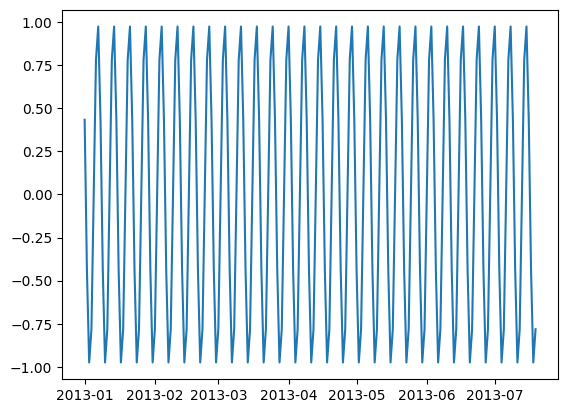

In [ ]:
plt.plot(df_converted.index[:200],df_converted["WDay_sin"][:200])

<ipython-input-67-464f9caf338c>:1: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  dataset = pd.concat(df_converted,df['sales'],axis=1)


TypeError: ignored

In [ ]:
pearsonCorr = df_converted.corrwith(df["sales"])
pearsonCorr

Year              0.297981
Month             0.158264
DayofMonth        0.027639
WDay              0.102231
Year_sin          0.297980
Year_cos          0.307616
Month_sin        -0.265298
Month_cos        -0.455306
DayofMonth_sin   -0.027442
DayofMonth_cos   -0.002131
WDay_sin         -0.055515
WDay_cos          0.294229
dtype: float64